# 確率ロボティクス最終課題
タイルワールドにおいて，エージェントの動きを強化学習のアルゴリズムを用いて生成する．
課題の詳細は[ここ](https://lab.ueda.tech/?page=prob_robot_2019)を参照のこと

### Defining the Agent

In [1]:
class Agent:
    def __init__(self):
        # U is up, D is down, L is left, R is right
        # u_r is upright, u_l is upleft
        # d_r is downright, d_l is downleft
        self.actions = ["U", "D", "L", "R", "u_r", "u_l", "d_r", "d_l"]
        self.pos = (0,0)

agent = Agent()

### Defining the environment
Configuring the tile world

In [2]:
size = 10

class State:
    def __init__(self,actions):
        self.Q = {}
        for a in actions:
            self.Q[a] = 0.0
        self.best_action = "u_r"
        self.goal = False
        
    def set_goal(self,actions):
        for a in actions:
            self.Q[a] = 0.0
        self.goal = True

states = [[State(agent.actions) for i in range(size)] for j in range(size)]
states[size-1][size-1].set_goal(agent.actions)

### Plot
The section for drawing

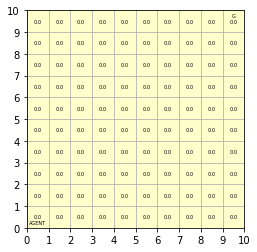

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
textsize = 5

def draw(mark_pos):
    fig, ax = plt.subplots()
    values = [[states[i][j].Q[states[i][j].best_action] for i in range(size)] for j in range(size)]
    mp = ax.pcolor(values, cmap = plt.cm.YlOrRd, vmin = 0, vmax = 8)
    ax.grid()
    ax.set_aspect(1)
    ax.set_xticks(range(size+1), minor = False)
    ax.set_yticks(range(size+1), minor = False)
    
    for x in range(len(values)):
        for y in range(len(values[0])):
            s = states[x][y]
            plt.text(x+0.5, y+0.5, int(1000*s.Q[s.best_action])/1000, ha = 'center', va = 'center', size = textsize)
            if states[x][y].goal:
                plt.text(x+0.5, y+0.75, "G", ha = 'center', va = 'center', size = textsize)
    
    plt.text(agent.pos[0]+0.5, agent.pos[1]+0.25, "AGENT", ha = 'center', va = 'center', size = textsize)

    if mark_pos == "all":
        for x in range(size):
            for y in range(size):
                if states[x][y].goal: continue
                plt.text(x+0.5, y+0.25, states[x][y].best_action, ha = 'center', va = 'center', size = textsize)
    elif mark_pos != None:
        s = states[mark_pos[0]][mark_pos[1]]
        plt.text(mark_pos[0]+0.5, mark_pos[1]+0.25, s.best_action, ha = 'center', va = 'center', size = textsize)

    plt.show()
    fig.clear()

draw(None)

#### State Transitions

In [5]:
import random

def state_transition(s_pos,a):
    if random.uniform(0,1) < 0.1: #Return the same position at a 10% chance
        return s_pos

    x, y = s_pos
    if a == "U": y += 1
    elif a == "D": y -= 1
    elif a == "R": x += 1
    elif a == "L": x -= 1
    elif a == "u_r": 
        if x < size-1 and y < size-1:
            x += 1
            y += 1
    elif a == "u_l":
        if x > 0 and y < size-1:
            x -= 1
            y += 1
    elif a == "d_r":
        if x < size-1 and y > 0:
            x += 1
            y -= 1
    elif a == "d_l":
        if x > 0 and y > 0:
            x -= 1
            y -= 1
    
    if x < 0: x = 0
    elif x >= size: x = size-1
    elif y < 0: y = 0
    elif y >= size: y = size-1
    
    return(x,y)

#### Policy (ε-greedy)

In [6]:
def e_greedy(s):
    if random.uniform(0,1) < 0.1: #Choose something random ata 10% chance
        return random.choice(agent.actions)

    else:
        best_a = None
        best_q = 1000000000
        for a in s.Q:
            if best_q > s.Q[a]:
                best_q = s.Q[a]
                best_a = a
        s.best_action = best_a
        return best_a

#### Processing step by step

In [7]:
alpha = 0.5
gamma = 1.0

def q_(s_pos,a):
    s = states[s_pos[0]][s_pos[1]]
    tmp = s.Q[a]
    for i in range(10):
        s_next_pos = state_transition(s_pos,a)
        s_next = states[s_next_pos[0]][s_next_pos[1]]
        a_next = e_greedy(s_next)
        if s_next.Q[a_next] > tmp:
            s_best = s_next
            s_best_pos = s_next_pos
            a_best = a_next
        elif s_next.Q[a_next] <= tmp: tmp = s_next.Q[a_next]
    
    q = (1.0 - alpha) * s.Q[a] + alpha * (1.0 + gamma * s_best.Q[a_best])
    
    print("s:" + str(s_pos) + " a:" + str(s_best_pos) + " a':" + a_best)
    print("-----")
    return s_best_pos, a_best, q

def one_trial_q():
    agent.pos = (random.randrange(size),random.randrange(size))
    a = e_greedy(states[agent.pos[0]][agent.pos[1]])
    if states[agent.pos[0]][agent.pos[1]].goal:
        return
    
    while True:
        s_best, a_best, q = q_(agent.pos, a)
        states[agent.pos[0]][agent.pos[1]].Q[a] = q
        agent.pos = s_best
        a = a_best
        if states[agent.pos[0]][agent.pos[1]].goal:
            break

for i in range(100):
    one_trial_q()
    draw("all")

UnboundLocalError: local variable 's_best' referenced before assignment